In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from tqdm import tqdm
import os
import glob
import einops, einsum
%matplotlib widget

In [2]:
def _name_from_path(filepath, path_in_name, path_sep, remove_extension):
    """Create a name from a filepath.

    Either return the name of the file (with the extension removed) or return
    the full filepath, where the path separators are replaced with `path_sep`.
    """
    if remove_extension:
        filepath = os.path.splitext(filepath)[0]
    if path_in_name:
        return filepath.replace(os.path.sep, path_sep)
    else:
        return os.path.basename(filepath)
    
def list_files_with_exts(filepath_pattern, ext_list, recursive=True):
    """This function lists all the files matching a pattern and with a an
    extension in a list of extensions.

    Parameters
    ----------
    filepath_pattern : str or list
        A filepath pattern or a list thereof. Filepath patterns can be be a
        single file, a directory, or a path with wildcards (e.g.,
        '/path/to/dir/prefix*').

    ext_list : list of str
        A list of file extensions to search for.

    recursive : bool, default=True
        Whether to search for files recursively.

    Returns
    -------
    list
        A list of file paths.
    """
    if isinstance(filepath_pattern, list):
        matches = []
        for fp in filepath_pattern:
            matches += list_files_with_exts(fp, ext_list, recursive=recursive)
        return sorted(set(matches))

    else:
        # make sure extensions all start with "." and are lowercase
        ext_list = ["." + ext.strip(".").lower() for ext in ext_list]

        if os.path.isdir(filepath_pattern):
            filepath_pattern = os.path.join(filepath_pattern, "*")

        # find all matches (recursively)
        matches = glob.glob(filepath_pattern)
        if recursive:
            for match in list(matches):
                matches += glob.glob(os.path.join(match, "**"), recursive=True)

        # filter matches by extension
        matches = [match for match in matches if os.path.splitext(match)[1].lower() in ext_list]
        return matches

In [3]:
def customDataLoader(filepath, name):
    df = pd.read_hdf(filepath)
    coordinates, confidences = {}, {}
    
    bodyparts = df.columns.get_level_values("bodyparts").unique().tolist()
    arr = df.to_numpy().reshape(len(df), 13, 4)
    coordinates[name] = arr[:, :, 0:3]
    confidences[name] = arr[:, :, 3]

    return coordinates, confidences, bodyparts

In [7]:
from tqdm import tqdm
import pandas as pd
from pathlib import Path
def customKeypointLoader(files_dir):

    filepaths = list_files_with_exts(files_dir, [".csv", ".h5"])

    coordinates, confidences, bodyparts = {}, {}, None
    path_in_name = True
    remove_extension = True
    path_sep = "-"
    for filepath in tqdm(filepaths, desc=f"Loading Keypoints", ncols=len(filepaths)):
        name = _name_from_path(filepath, path_in_name, path_sep, remove_extension) # to add
        try:
            new_coordinates, new_confidences, bodyparts = customDataLoader(filepath, name)
        except Exception as e:
            print(f"Error loading {filepath}")
            raise e
        coordinates.update(new_coordinates)
        confidences.update(new_confidences)
    return coordinates, confidences, bodyparts

In [8]:
# goal: produce scatter (cols, numb_frames, color= confidence per session)
data_dir = r"D:\P05_3DRIG_YE-LP\e01_mouse_hunting\dlc_3d_data"

In [9]:
coordinates, confidences , bodyparts = customKeypointLoader(data_dir)

Loading Keypoints:   0%|                 | 0/64 [00:00<?, ?it/s]

Loading Keypoints: 100%|████████| 64/64 [00:06<00:00, 10.35it/s]


In [72]:
from scipy.signal import medfilt
from scipy.ndimage import gaussian_filter

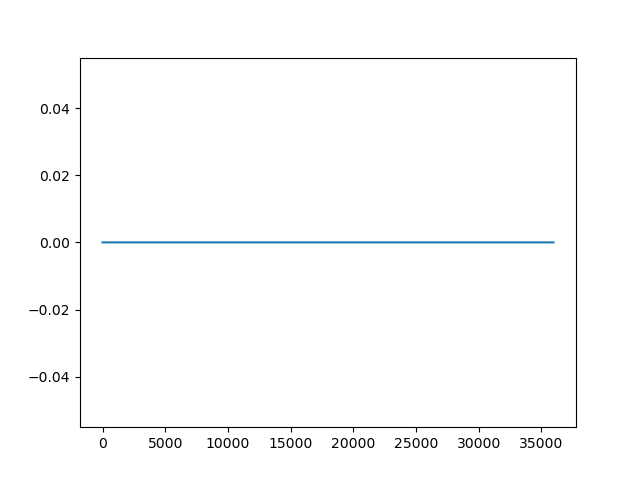

In [74]:
plt.figure()
plt.plot(nan_entries)

Plotting:   0%|                                                              | 0/64 [00:00<?, ?it/s]C:\Users\SNeurobiology\AppData\Local\Temp\ipykernel_2588\4075089616.py:17: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(np.ones(n_points) * idx+0.2, np.arange(n_points)*nan_entries, marker='_', c="red", alpha=0.5, cmap='viridis', s=5)
Plotting: 100%|█████████████████████████████████████████████████████| 64/64 [00:01<00:00, 59.63it/s]


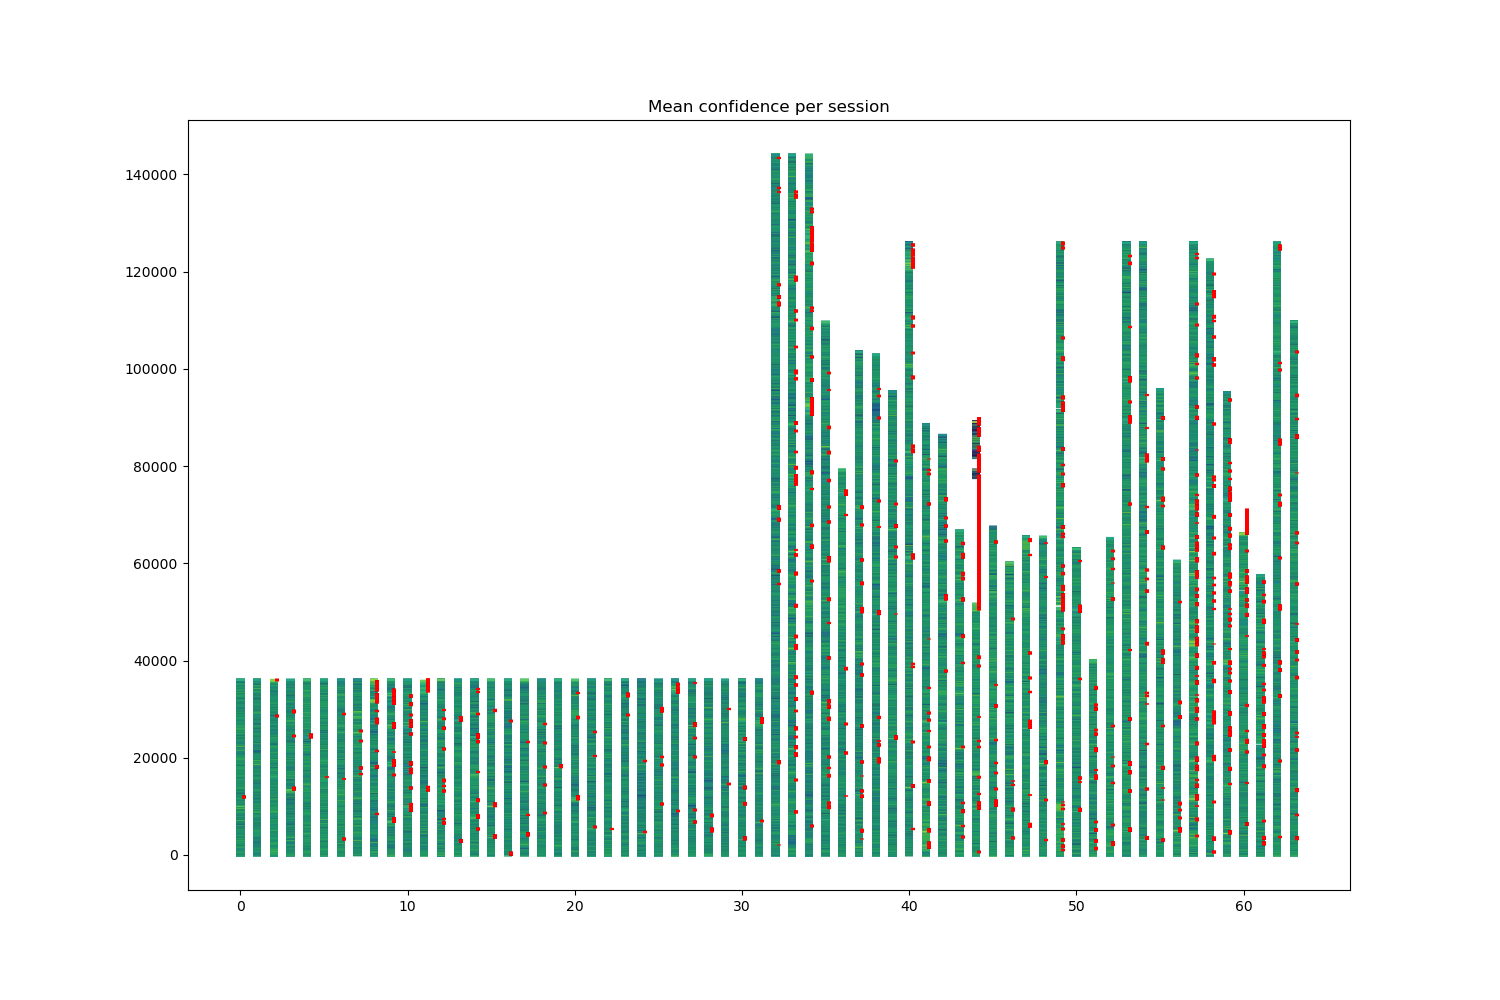

In [100]:
fig =  plt.subplots(figsize=(15, 10))


for idx, (key, value) in tqdm(list(enumerate(confidences.items())), desc="Plotting", ncols=100):
    mean_confs = einops.reduce(value, 'frames k -> frames', 'mean')
    n_points = mean_confs.shape[0]
    # use - lines as marker
    plt.scatter(np.ones(n_points) * idx, np.arange(n_points), marker='_', c =mean_confs, alpha=0.5, cmap='viridis_r', clim=(.22, .74))

    nan_entries = np.full((n_points,), 0)
    nan_entries[np.isnan(mean_confs)] = 1
    nan_entries = gaussian_filter(nan_entries, 10).astype(float)
    # nan_entries[1:][np.isnan(mean_confs[1:]) & np.isnan(mean_confs[:-1])] = 1
    #print(np.nansum(nan_entries))
    nan_entries[nan_entries == 0] = np.nan
    #plt.plot(nan_entries)
    plt.scatter(np.ones(n_points) * idx+0.2, np.arange(n_points)*nan_entries, marker='_', c="red", alpha=0.5, cmap='viridis', s=5)

    # print(np.nanmin(mean_confs), np.nanmax(mean_confs))
    


plt.title("Mean confidence per session")
plt.show()
    
    


For the two videos with a lot of nans: the mouse is removed from the arena. Just by looking at the videos with a bad PCA I don't see any striking difference compared with other videos

In [92]:
np.nanmin(mean_confs), np.nanmax(mean_confs)

(0.2600479068664404, 0.6890482604503632)

(array([2.1500e+02, 2.9370e+03, 1.3457e+04, 2.5359e+04, 2.3774e+04,
        1.3626e+04, 4.9890e+03, 1.1660e+03, 1.3900e+02, 2.2000e+01]),
 array([0.26004791, 0.30294794, 0.34584798, 0.38874801, 0.43164805,
        0.47454808, 0.51744812, 0.56034815, 0.60324819, 0.64614823,
        0.68904826]),
 <BarContainer object of 10 artists>)

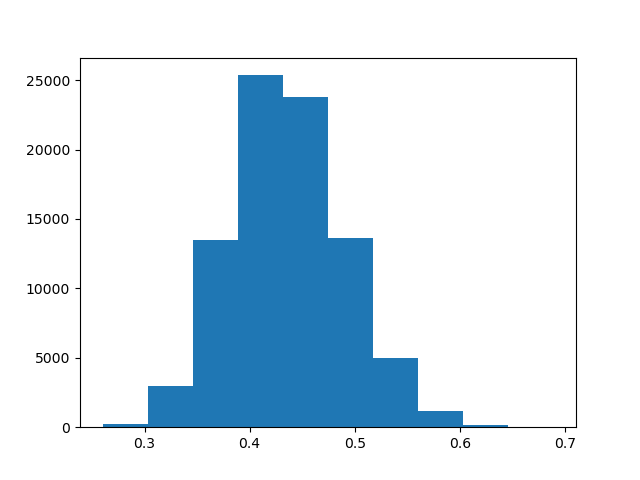

In [90]:
plt.figure()
plt.hist(mean_confs)

Keypoint 12: 100%|██████████████████████████████████████████████████| 64/64 [00:02<00:00, 29.54it/s]


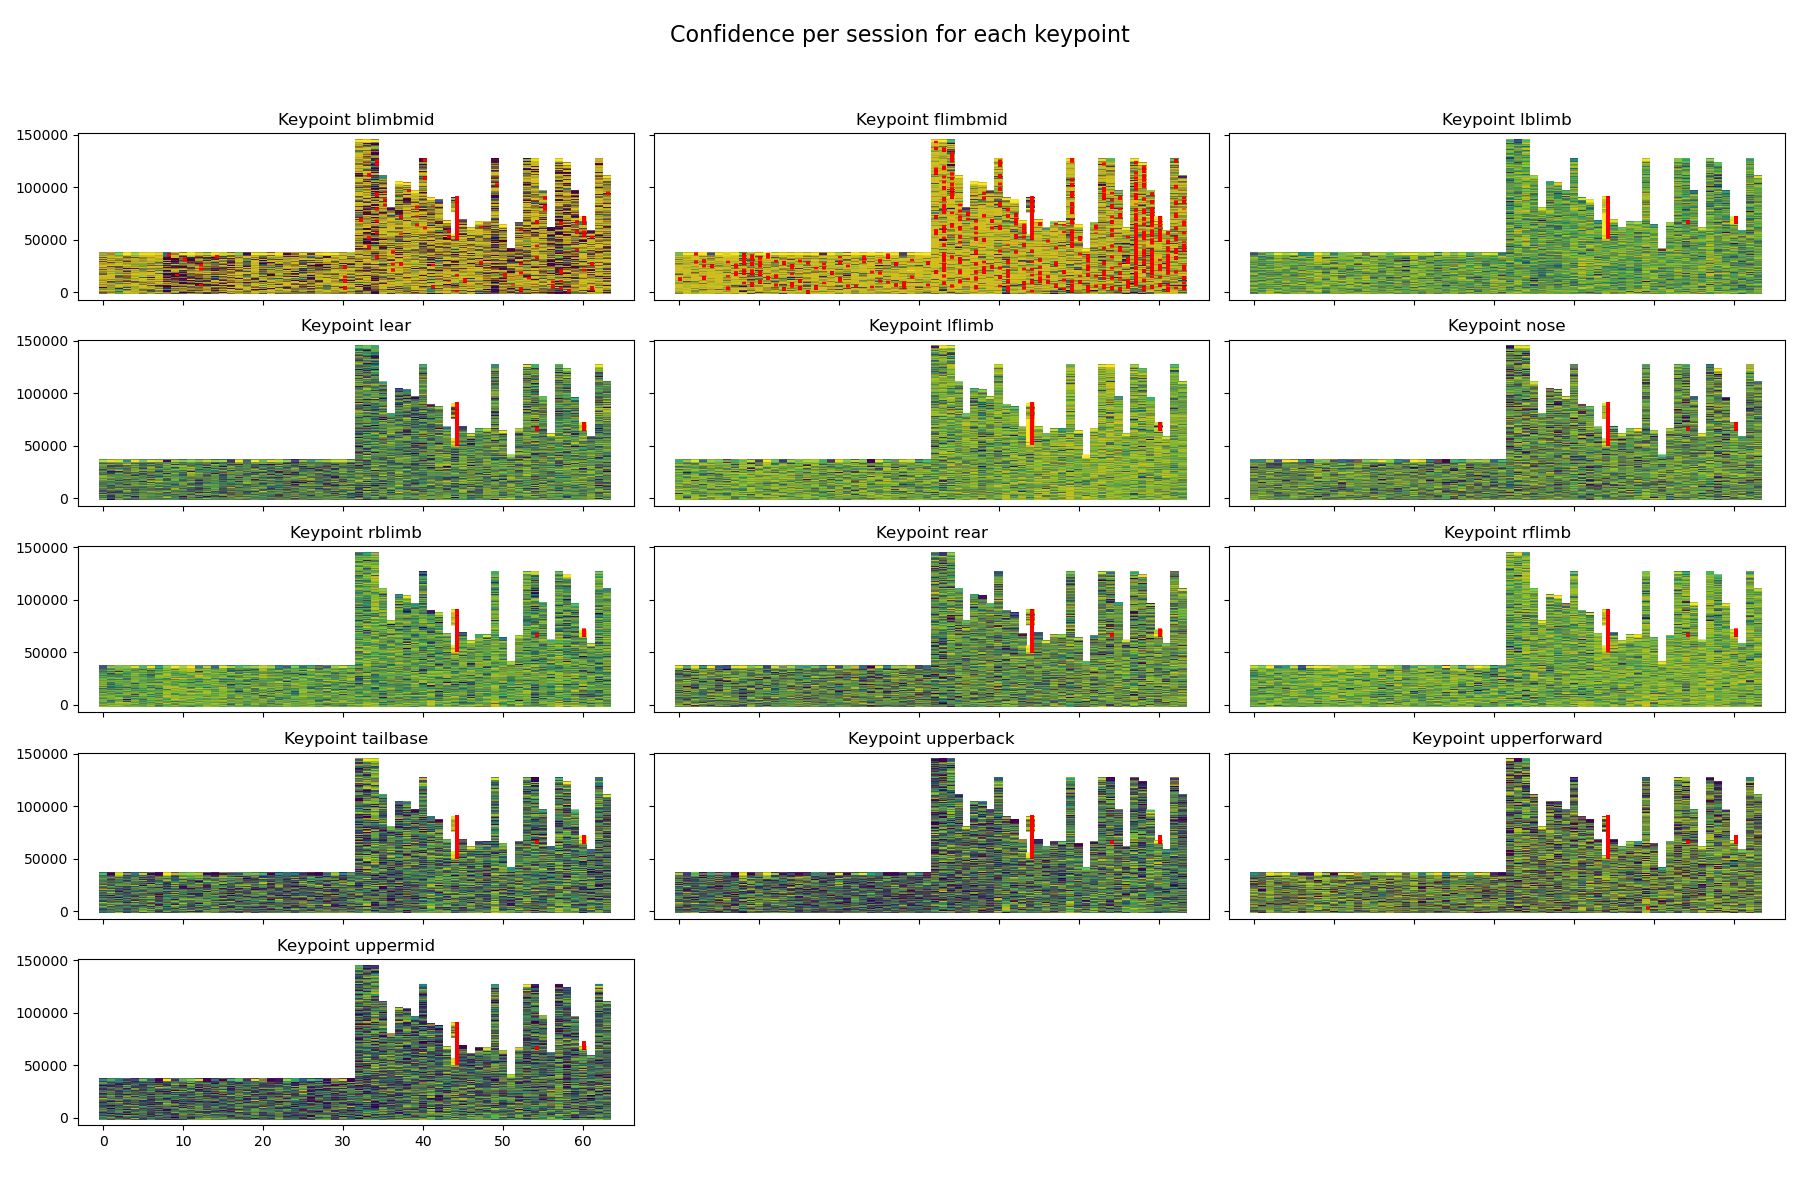

In [98]:
fig, axes = plt.subplots(5, 3, figsize=(18, 12), sharex=True, sharey=True)
axes = axes.flatten()  # Make indexing easier


for kp, bodypart in enumerate(bodyparts):
    ax = axes[kp]
    for idx, (key, value) in tqdm(list(enumerate(confidences.items())), desc=f"Keypoint {kp}", ncols=100):
        
        kp_confs = value[:, kp]  
        n_points = kp_confs.shape[0]
        
       
        ax.scatter(np.ones(n_points) * idx, np.arange(n_points), marker='_', c=kp_confs, 
                   alpha=0.5, cmap='viridis_r', clim=(.26, .7))


        nan_entries = np.full((n_points,), 0)
        nan_entries[np.isnan(kp_confs)] = 1
        nan_entries = gaussian_filter(nan_entries, 10).astype(float)
        nan_entries[nan_entries == 0] = np.nan
        ax.scatter(np.ones(n_points) * idx + 0.2, np.arange(n_points) * nan_entries, 
                   marker='_', c="red", alpha=0.5, s=5)

    ax.set_title(f"Keypoint {bodypart}")

# Hide unused subplot (14th)
if len(axes) > len(bodyparts):
    for i in range(len(bodyparts), len(axes)):
        axes[i].axis('off')

fig.suptitle("Confidence per session for each keypoint", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [97]:
for idx, bodypart in enumerate(bodyparts):
    print(f"{idx}: {bodypart}")

0: blimbmid
1: flimbmid
2: lblimb
3: lear
4: lflimb
5: nose
6: rblimb
7: rear
8: rflimb
9: tailbase
10: upperback
11: upperforward
12: uppermid


In [106]:
from scipy.ndimage import binary_dilation, binary_erosion


In [101]:
def nan_mask_cleaner(confidence_array, fps=30, threshold_sec=3):
    """
    confidence_array: (frames,) — 1D array with NaNs
    fps: frames per second
    threshold_sec: how many seconds of NaNs you want to remove (e.g., 3)
    """
    nan_mask = np.isnan(confidence_array)  # True where NaN

    # Structuring element: how many consecutive frames count as a "long" gap
    kernel_size = int(fps * threshold_sec)
    structure = np.ones(kernel_size)

    # Remove short gaps (i.e., erosion removes narrow stretches of True)
    cleaned_mask = binary_erosion(nan_mask, structure=structure)
    cleaned_mask = binary_dilation(cleaned_mask, structure=structure)

    return cleaned_mask  # boolean mask of length `frames`


In [119]:
exp_bad_array = np.asanyarray(list(confidences.values())[44])

In [120]:
exp_bad_array = einops.reduce(exp_bad_array, 'frames k -> frames', 'mean')

In [124]:
bad_frames = nan_mask_cleaner(exp_bad_array, fps=30, threshold_sec=4)

In [125]:
exp_bad_array.shape

(89759,)

In [126]:
exp_bad_array[~bad_frames].shape

(57762,)

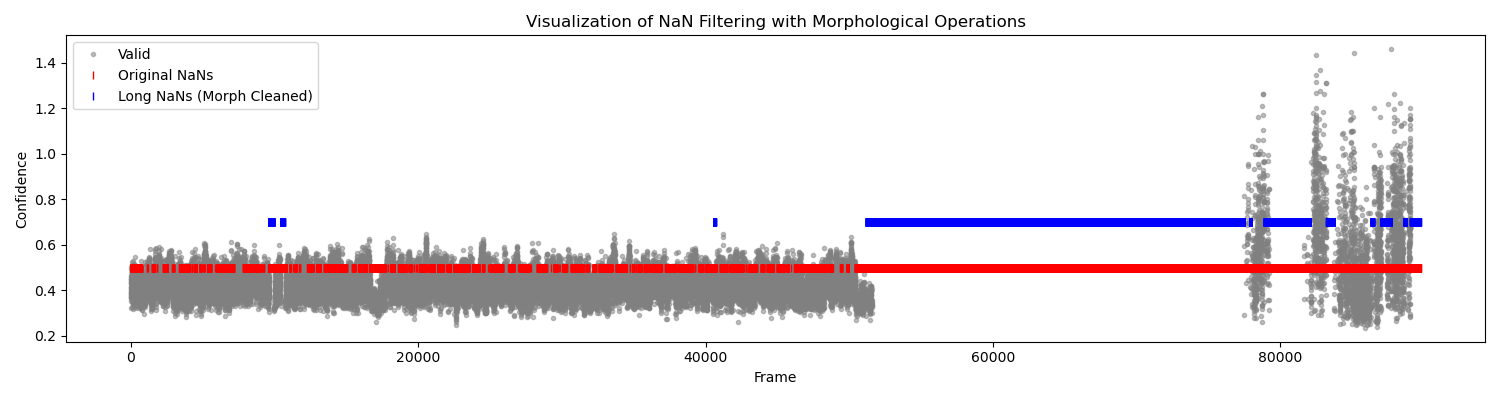

In [ ]:

conf = exp_bad_array
mask = bad_frames
frames = np.arange(len(exp_bad_array))
fig, ax = plt.subplots(figsize=(15, 4))

# Plot valid points
ax.plot(frames[~np.isnan(conf)], conf[~np.isnan(conf)], '.', color='gray', alpha=0.5, label='Valid')

# Plot original NaNs
ax.plot(frames[np.isnan(conf)], np.full(np.isnan(conf).sum(), 0.5), '|', color='red', label='Original NaNs')

# Plot long NaNs identified by mask
ax.plot(frames[mask], np.full(mask.sum(), 0.7), '|', color='blue', label='Long NaNs (Morph Cleaned)')

ax.legend()
ax.set_title("Visualization of NaN Filtering with Morphological Operations")
ax.set_xlabel("Frame")
ax.set_ylabel("Confidence")
plt.tight_layout()
plt.show()


### Analysis of variance per video

Check  whether we can see a reduction in the variance in the videos that contain an interaction 

In [10]:
from movement.kinematics import compute_displacement, compute_acceleration


motion_energy = {}

for recording, array in tqdm(coordinates.items()):
    displacements = np.diff(array, axis=0)  # shape: (n_frames - 1, n_keypoints, 3)

    frame_energy = np.linalg.norm(displacements, axis=(1, 2))  # shape: (n_frames - 1,)
    motion_energy[recording] = frame_energy

    

100%|██████████| 64/64 [00:01<00:00, 60.86it/s] 


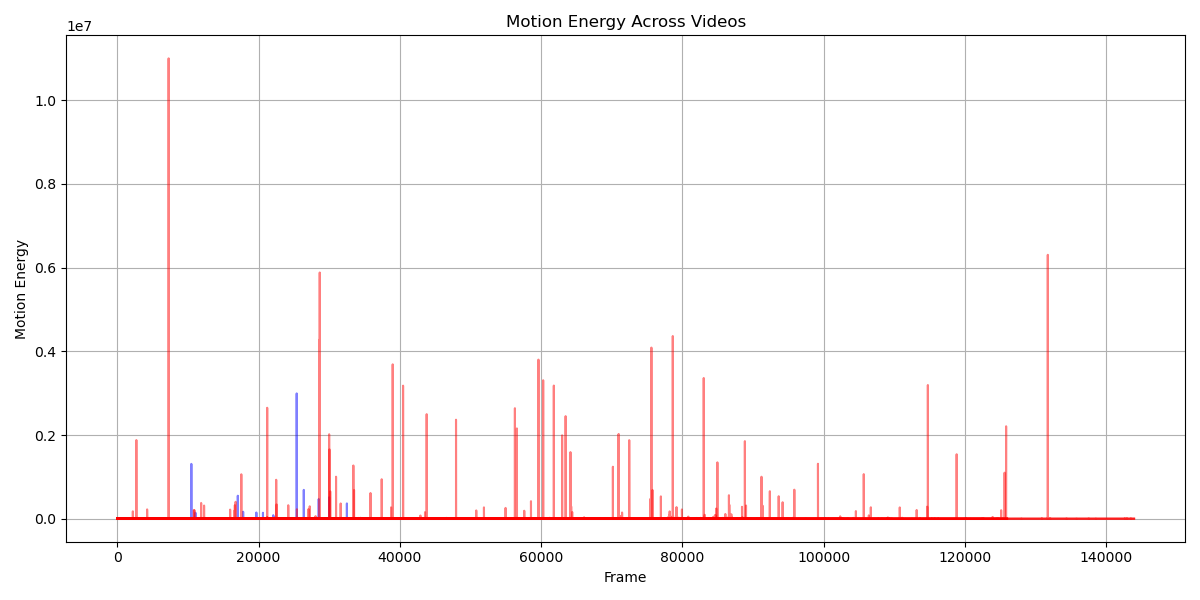

In [11]:
# divide them into 2 parts 


fig, ax = plt.subplots(figsize=(12, 6))

for idx , (name, energy) in enumerate(motion_energy.items()):
    if idx > 31:
        ax.plot(energy, c='r', alpha=0.5)
    else:
        ax.plot(energy, c='b', alpha=0.5)

ax.set_title("Motion Energy Across Videos")
ax.set_xlabel("Frame")
ax.set_ylabel("Motion Energy")
# plt.xlim(0, 30000)
# plt.ylim(0,1000)
plt.grid(True)
plt.tight_layout()
plt.show()


### Do speed filtering but not keypoint relative, but mouse relative